# Steps to implement Prompt Chaining 

1. **Define the Task**: Break down the task into smaller sub-tasks. ex: Generating detailed report -> 'gather data', 'analyze data' and 'write summary'.

2. **Create Nodes**: Each subtask becomes a node in LangGraph structure. A node could be a prompt that instructs the model to perform a specific action. ex: 'Summarize the following text'

3. **Establish edges**: Edges define the sequence and dependencies between nodes. ex: output of 'gather data' node flows into 'analyze data' node.

4. **Execute the Graph**: LangGraph processes the nodes in order, passing information along the edges. Model generates response step-by-step, refining the output as it progresses through the chain. 

5. **Iterate if needed**: LangGraph supports conditional logic and loops, so you can revisit earlier nodes or adjust the flow based on intermediate results.


### Usecase: Generate a Story
* `Start`
* `Node 1` will generate a story 
* Then we will apply a condition 
* If the story fails, `Node 1` will generate another story and try the condition
* If the story passes, it proceeds to further nodes
* `Node 2` will improve the story 
* `Node 3` will polish the story
* `End`

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

from langchain_groq import ChatGroq
llm = ChatGroq(model="gemma2-9b-it")

llm.invoke("Hello")

AIMessage(content='Hello! 👋\n\nHow can I help you today? 😊\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 10, 'total_tokens': 25, 'completion_time': 0.027272727, 'prompt_time': 0.001172151, 'queue_time': 0.25092296399999997, 'total_time': 0.028444878}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--7b15c70d-817f-49a4-8acc-6553214f0a29-0', usage_metadata={'input_tokens': 10, 'output_tokens': 15, 'total_tokens': 25})

In [10]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image
from langchain_core.messages import HumanMessage, SystemMessage

# graph state
class State(TypedDict):
    topic: str
    story: str
    improved_story: str
    final_story: str

# creating nodes
def generate_story(state: State):
    prompt = [
        SystemMessage(content=f"You are a helpful Story teller."),
        HumanMessage(content=f"Write a one sentence story premise about {state["topic"]}")
    ]
    msg = llm.invoke(prompt)
    return {"story":msg.content}

def check_conflict(state: State):
    if "?" in state["story"] or "!" in state["story"]:
        return "fail"
    return "pass"

def improve_story(state: State):
    prompt = [
        SystemMessage(content=f"You are a helpful Literature assistant."),
        HumanMessage(content=f"Enhance this story premise with vivid details: {state["story"]}")
    ]
    msg = llm.invoke(prompt)
    return {"improved_story":msg.content}

def polish_story(state: State):
    prompt = [
        SystemMessage(content=f"You are an expert Story writer."),
        HumanMessage(content=f"Generate a story by adding an unexpected twist to this story premise: {state["story"]}")
    ]
    msg = llm.invoke(prompt)
    return {"final_story":msg.content}

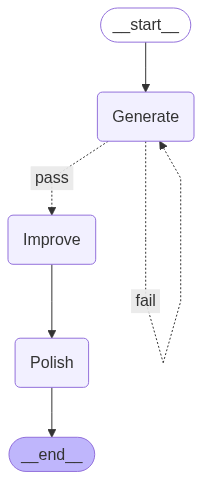

In [11]:
# build the graph
graph = StateGraph(State)
graph.add_node("Generate", generate_story)
graph.add_node("Improve", improve_story)
graph.add_node("Polish", polish_story)

# define the edges
graph.add_edge(START, "Generate")
graph.add_conditional_edges("Generate", check_conflict, {"pass":"Improve", "fail":"Generate"})
graph.add_edge("Improve", "Polish")
graph.add_edge("Polish", END)

# compile the graph
compiled_graph = graph.compile()

# display the graph
display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [12]:
# Run the graph
state = {"topic":"Alien Invasion"}
result = compiled_graph.invoke(state)
result

{'topic': 'Alien Invasion',
 'story': "While celebrating a global unity festival, humanity's greatest scientific minds discover a message in the stars, not of peace, but of imminent invasion.  \n",
 'improved_story': 'The Unity Festival pulsed with a vibrant kaleidoscope of life.  Every nation on Earth, from the sun-drenched shores of the Mediterranean to the snow-capped peaks of the Himalayas, had converged upon the sprawling metropolis built on the reclaimed banks of the Mississippi.  A symphony of languages, a tapestry of customs, and a chorus of laughter painted a picture of a world united.  Giant holographic projections of Earth danced in the sky, showcasing the planet\'s interconnectedness.  \n\nIn the heart of this joyous chaos, nestled amidst the throngs of revelers, stood the Zenith Observatory – a gleaming monument to humanity\'s scientific prowess.  Inside, the world\'s brightest minds, draped in the vibrant attire of their respective cultures, huddled around a massive, puls

In [13]:
print("Story")
print(result["story"])
print("Improved Story")
print(result["improved_story"])
print("Final Story")
print(result["final_story"])

Story
While celebrating a global unity festival, humanity's greatest scientific minds discover a message in the stars, not of peace, but of imminent invasion.  

Improved Story
The Unity Festival pulsed with a vibrant kaleidoscope of life.  Every nation on Earth, from the sun-drenched shores of the Mediterranean to the snow-capped peaks of the Himalayas, had converged upon the sprawling metropolis built on the reclaimed banks of the Mississippi.  A symphony of languages, a tapestry of customs, and a chorus of laughter painted a picture of a world united.  Giant holographic projections of Earth danced in the sky, showcasing the planet's interconnectedness.  

In the heart of this joyous chaos, nestled amidst the throngs of revelers, stood the Zenith Observatory – a gleaming monument to humanity's scientific prowess.  Inside, the world's brightest minds, draped in the vibrant attire of their respective cultures, huddled around a massive, pulsating screen.  They were not there to celebrat